# Classifier cross-validation

### Goals of this script
1. import labels (already trimmed but not shifted)
2. shift labels to account for hemodynamic lag
3. load voxel x TR matrix for ROI(s) of interest
4. reshape data (remove all fixation timepoints)
5. run classifiers and cross-validate on other localizer run (train on run1, test on run2 and vice-versa)
    - model 1: solver='liblinear', class_weight=None
    - model 2: solver='liblinear', class_weight='balanced'
    - model 3: solver='lbfgs', class_weight=None
    - model 4: solver='lbfgs', class_weight='balanced'
6. For each subject, save the average prediction probabilities for each classifier as well as the TR-by-TR prediction probabilities.
    - classifier=['face_classifier', 'scene_classifier', 'object_classifier']
    - trial_type=['face_trials', 'scene_trials', 'object_trials']
        - classifier_scores[classifier][mask][run]
        - prediction_probabilities[classifier][mask][TR]
        - avg_classifier_evidence[trial_type][mask][run][classifier]
        - num_voxels[mask]

## Define subject

In [6]:
sub = 'sub-005'
subNum = '005'
ses = 'ses-01'
task = 'imagine'
run = 8

ROIs=['bilateral_hippo','bilateral_oc-temp']

## Import necessary packages

In [7]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import numpy as np
import nibabel as nib
import nilearn
from nilearn.input_data import NiftiMasker,  MultiNiftiMasker
from nilearn.masking import intersect_masks
from nilearn import image
from nilearn import plotting
from nilearn.plotting import plot_roi
from scipy import stats
from sklearn import preprocessing
import matplotlib.pyplot as plt 
import scipy.io
#from mpi4py import MPI
import os
import pickle 
import time
from scipy.sparse import random
from scipy.stats import zscore
from scipy.spatial.distance import euclidean
from pathlib import Path
from shutil import copyfile
import seaborn as sns
import importlib
import csv

# Import machine learning libraries
import sklearn
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, PredefinedSplit
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score

%matplotlib inline 
%autosave 5

Autosaving every 5 seconds


In [8]:
from platform import python_version
print('The python version is {}.'.format(python_version()))
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The numpy version is {}.'.format(np.__version__))
print('The nilearn version is {}.'.format(nilearn.__version__))
print('The seaborn version is {}.'.format(sns.__version__))

The python version is 3.9.10.
The scikit-learn version is 1.0.2.
The numpy version is 1.20.3.
The nilearn version is 0.8.1.
The seaborn version is 0.11.2.


In [9]:
#find out how much to trunc from beginning and end
file_name = '/jukebox/norman/karina/adderzip_fMRI/adderzip/data/supanalysis/TR_count/TR_count_%s.csv' % (subNum)

countData = open(file_name)
countData = csv.reader(countData)
countData = list(countData)
countData = countData[1::]
countData = np.array(countData)
countData = np.float64(countData)

n_trunc_beginning= int(countData[run-1,1])#Number of volumes to trim from beginning of this run
n_trunc_end= int(countData[run-1,3]) #Number of volumes to trim from end of run
n_task= int(countData[run-1,2])

## Load settings

In [10]:
# Set printing precision
np.set_printoptions(precision=2, suppress=True)

# load some helper functions
sys.path.insert(0, '/jukebox/norman/karina/adderzip_fMRI/adderzip/code/analysis/mainanalysis')
import adderzip_utils_imagine
from adderzip_utils_imagine import load_adderzip_stim_labels_imagine,load_adderzip_epi_data, shift_timing, label2TR, mask_data

# load some constants
from adderzip_utils_imagine import adderzip_dir, adderzip_bids_dir, adderzip_label_dict_imagine,adderzip_TR, adderzip_hrf_lag, run_names, run_order_start, n_runs, TRs_run

importlib.reload(adderzip_utils_imagine)

print('TASK:', task)
print('LIST OF TASKS:', run_names)
task_index = run_names.index(task)
print('task index:', task_index)
print('')

n_runs_imagine = n_runs[task_index]

trials_run_imagine = 32
trials_run_extra_imagine = 48

anat_dir=adderzip_bids_dir + 'derivatives/deface/'
out_dir= adderzip_bids_dir + 'derivatives/firstlevel/%s/' % sub
mask_fold = adderzip_bids_dir + 'derivatives/firstlevel/%s/masks/' % sub
data_dir='/jukebox/norman/karina/adderzip_fMRI/adderzip/data/mainanalysis/output'

ses1_dir=adderzip_bids_dir + 'derivatives/fmriprep/%s/ses-01/func/' % sub

print('bids dir = %s' % (adderzip_bids_dir))
print('')
print('subject dir = %s' % (ses1_dir))
print('')
print('output dir = %s' % (out_dir))
print('')
print('ROIs = %s' % (ROIs))
print('Labels = %s' % (adderzip_label_dict_imagine))
print('number of runs = %d' % (n_runs_imagine))
print('TR = %s seconds' % (adderzip_TR))
print('TRs before trimming for run %i= %s' % (run,n_trunc_beginning+n_trunc_end+n_task))
print('%d volumes trimmed from beginning of each run' % (n_trunc_beginning))
print('%d volumes trimmed from end of each run' % (n_trunc_end))
print('TRs per run after trimming = %s' % (n_task))

TASK: imagine
LIST OF TASKS: ['imagine']
task index: 0

bids dir = /jukebox/norman/karina/adderzip_fMRI/adderzip/data/bids/

subject dir = /jukebox/norman/karina/adderzip_fMRI/adderzip/data/bids/derivatives/fmriprep/sub-005/ses-01/func/

output dir = /jukebox/norman/karina/adderzip_fMRI/adderzip/data/bids/derivatives/firstlevel/sub-005/

ROIs = ['bilateral_hippo', 'bilateral_oc-temp']
Labels = {0: 'Scenes', 1: 'Faces'}
number of runs = 2
TR = 1.5 seconds
TRs before trimming for run 8= 160
5 volumes trimmed from beginning of each run
11 volumes trimmed from end of each run
TRs per run after trimming = 144


## Stimulus labels  - load truncated stimulus labels and shift labels 4.5 sec (3 TRs)

imagineInfo (32, 8)
timeInfo (32,)
stim_label has shape:  (32, 10)

stim_label looks like this
[[ 0.  16.  10.   3.   0.   1.   0.   9.   7.5  7.5]
 [ 1.  11.  38.   2.   3.   0.   1.   4.  15.   7.5]
 [ 2.   5.  47.   1.   5.   0.   0.   6.  21.   6. ]
 [ 3.  14.  14.   2.   6.   0.   1.   7.  28.5  7.5]
 [ 4.  18.  44.   3.   2.   1.   0.  11.  36.   7.5]]
...
[[ 27.   52.   18.    5.    4.    1.    1.   13.  189.    6. ]
 [ 28.   15.   40.    2.    7.    0.    1.    8.  195.    6. ]
 [ 29.   53.    8.    5.    5.    1.    1.   14.  202.5   7.5]
 [ 30.   51.   32.    5.    3.    1.    1.   12.  208.5   6. ]
 [ 31.    8.   30.    2.    0.    0.    1.    1.  216.    7.5]]


Text(0.5, 0, 'Trial')

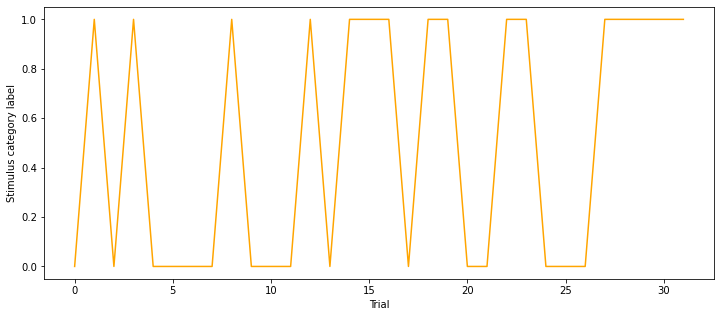

In [19]:
# load stimulus labels from regressor file for each run and concatenate
# NOTE: Regressor files are already trimmed (beginning only), but not shifted, in Matlab using gen_loc_regressor_0101.m


stim_label = load_adderzip_stim_labels_imagine(subNum,run)
        
print('stim_label has shape: ', np.shape(stim_label))
print('')
print('stim_label looks like this')
print(stim_label[:5,:])
print('...')
print(stim_label[-5:,:])
#print(stim_label)


# Plot the labels
f, ax = plt.subplots(1,1, figsize = (12,5))
ax.plot(stim_label[:trials_run_imagine,6], c='orange')
ax.set_ylabel('Stimulus category label')
ax.set_xlabel('Trial')

original shape (32, 10)
fix trial number and expTime
delayTime 216.0
stim_label looks like this
[[ 0.  16.  10.   3.   0.   1.   0.   9.   7.5  7.5  7.5]
 [ 1.  11.  38.   2.   3.   0.   1.   4.  15.   7.5 15. ]
 [ 2.   5.  47.   1.   5.   0.   0.   6.  21.   6.  21. ]
 [ 3.  14.  14.   2.   6.   0.   1.   7.  28.5  7.5 28.5]
 [ 4.  18.  44.   3.   2.   1.   0.  11.  36.   7.5 36. ]]
...
[[ 27.   52.   18.    5.    4.    1.    1.   13.  189.    6.  189. ]
 [ 28.   15.   40.    2.    7.    0.    1.    8.  195.    6.  195. ]
 [ 29.   53.    8.    5.    5.    1.    1.   14.  202.5   7.5 202.5]
 [ 30.   51.   32.    5.    3.    1.    1.   12.  208.5   6.  208.5]
 [ 31.    8.   30.    2.    0.    0.    1.    1.  216.    7.5 216. ]]
change time to TR and trim beginning
new shape after adding new column with trimmed TRs (32, 13)

stim_label_allruns looks like this
[[ 0.  16.  10.   3.   0.   1.   0.   9.   7.5  7.5  7.5  0.   5. ]
 [ 1.  11.  38.   2.   3.   0.   1.   4.  15.   7.5 15.   5.  

Text(0.5, 0, 'TR')

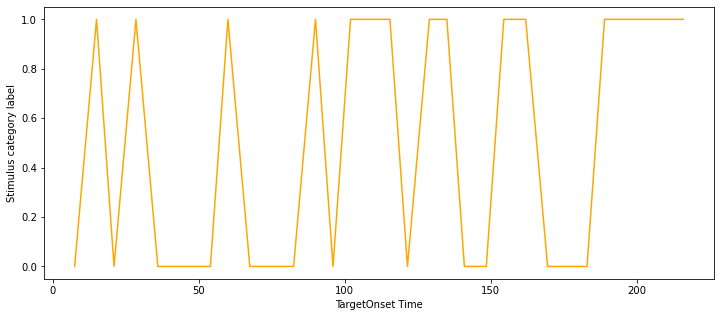

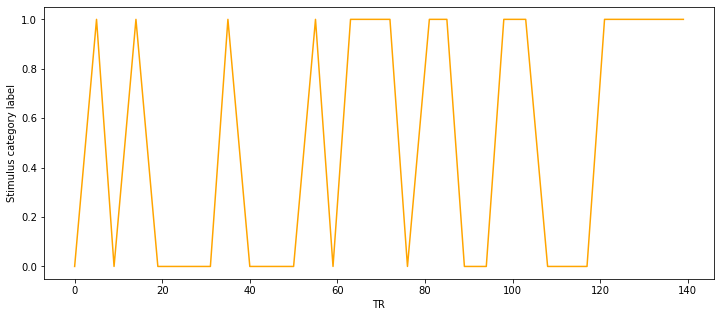

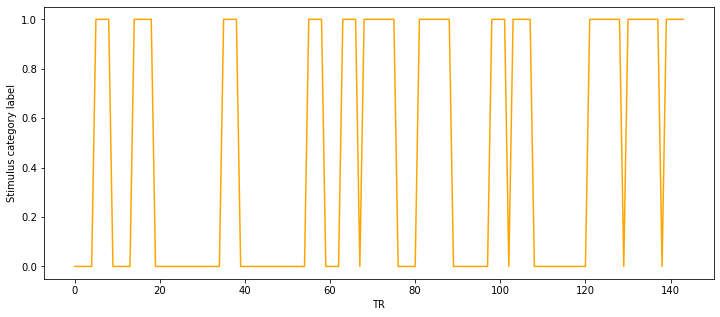

In [20]:
#reshape and edit stim labels format
print('original shape', np.shape(stim_label))
n_col_orig = stim_label.shape[1]

#add new column for new reshaped data
zeros = np.zeros((stim_label.shape[0],1))
ones = np.ones((stim_label.shape[0],1))

#trial number and experiment time is restarting at 0 for each run. fix it.
print('fix trial number and expTime')
#trial number 
#stim_label[:,0] = np.arange(stim_label.shape[0])

#exp time
if stim_label.shape[1] ==n_col_orig:
    stim_label = np.hstack((stim_label,zeros))
    delayTime = stim_label[trials_run_imagine-1,8]
    print('delayTime',delayTime)
    newCol_expTime = stim_label[:,8]
    #newCol_expTime[trials_run_imagine:]= newCol_expTime[trials_run_imagine:] + delayTime
    stim_label[:,10] = newCol_expTime

print('stim_label looks like this')
print(stim_label[:5,:])
print('...')
print(stim_label[-5:,:])

# Plot the labels for 1st run
f, ax = plt.subplots(1,1, figsize = (12,5))
ax.plot(stim_label[:trials_run_imagine,10],stim_label[:trials_run_imagine,6], c='orange')
ax.set_ylabel('Stimulus category label')
ax.set_xlabel('TargetOnset Time')

#stim_label = np.hstack((stim_label,zeros))


#change targetOnset time to TR
print('change time to TR and trim beginning')
#truncate initial 
if stim_label.shape[1]<n_col_orig+2:
    stim_label = np.hstack((stim_label,zeros))
    
    #change time to TR
    newCol_TR = np.float64(stim_label[:,10])
    newCol_TR = newCol_TR / np.float64(adderzip_TR)
    
    #trim TR from beginning
    newCol_TR = newCol_TR - n_trunc_beginning

    stim_label[:,11] = newCol_TR
    
    #add TR end
    stim_label = np.hstack((stim_label,zeros))
    
    TRcount = stim_label[:,9]
    TRcount = TRcount/np.float64(adderzip_TR)
    newCol_TR_end = newCol_TR + TRcount
    
    stim_label[:,12] = newCol_TR_end

    print('new shape after adding new column with trimmed TRs', np.shape(stim_label))

print('')
print('stim_label_allruns looks like this')
print(stim_label[:5,:])
print('...')
print(stim_label[-5:,:])

# Plot the labels 
f, ax = plt.subplots(1,1, figsize = (12,5))
ax.plot(stim_label[:trials_run_imagine,11:12],stim_label[:trials_run_imagine,6], c='orange')
ax.set_ylabel('Stimulus category label')
ax.set_xlabel('TR')

total_TRs = n_task
label_mat = np.zeros((total_TRs,3))
label_mat[:,1] = np.arange(total_TRs)

for eachRow in range(stim_label.shape[0]):
    TR_start = int(stim_label[eachRow, 11])
    TR_end = int(stim_label[eachRow, 12])
    
    thisLabel = stim_label[eachRow, 6]
    
    label_mat[TR_start:TR_end,0] = eachRow
    label_mat[TR_start:TR_end,2] = thisLabel

print('')
print('label_mat looks like this')
print(label_mat[:5,:])
print('...')
print(label_mat[-5:,:])

# Plot the labels 
f, ax = plt.subplots(1,1, figsize = (12,5))
ax.plot(label_mat[:,1],label_mat[:,2], c='orange')
ax.set_ylabel('Stimulus category label')
ax.set_xlabel('TR')

shift by 3 TRs
stim_label_shifted shape (144, 3)

stim_label looks like this
[[0. 3. 0.]
 [0. 4. 0.]
 [0. 5. 0.]
 [0. 6. 0.]
 [0. 7. 0.]]
[[ 31. 142.   1.]
 [ 31. 143.   1.]
 [ 31.   0.   1.]
 [ 31.   0.   1.]
 [ 31.   0.   1.]]


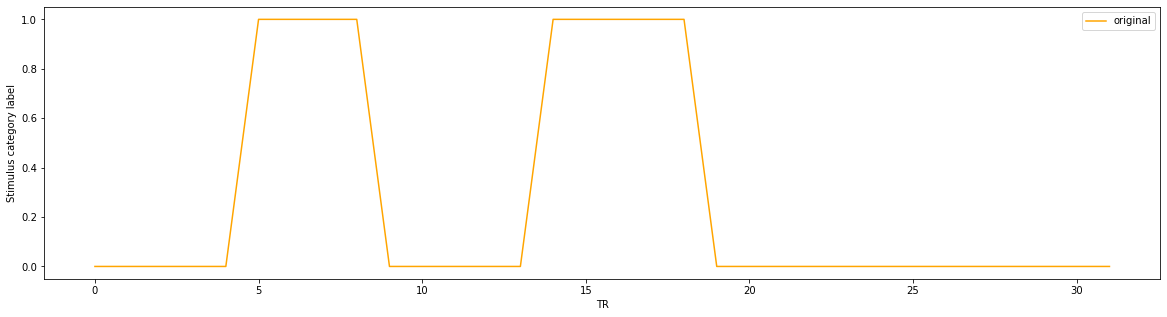

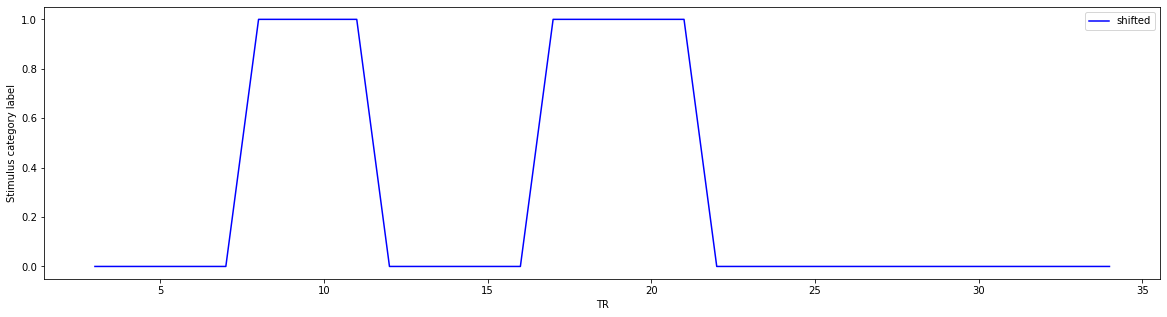

In [22]:
# Shift the data labels to account for hemodynamic lag
shift_size = int(adderzip_hrf_lag / adderzip_TR)  # Convert the shift into TRs
print('shift by %s TRs' % (shift_size))

#add shift to TRs
TRs = label_mat[:,1] 
ones = np.ones(int(np.shape(TRs)[0]))
shiftBy = ones * shift_size
shiftBy = np.float64(shiftBy)
TRs = np.float64(TRs)
shiftedTRs = TRs + shiftBy
#shiftBy = int(shift_size+1) #last TR from last run also got truncated from bold data
shiftBy = int(shift_size) 
shiftedTRs[-shiftBy:] = 0
stim_label_shifted = np.copy(label_mat)
stim_label_shifted[:,1] = shiftedTRs


# Plot the original and shifted labels
f, ax = plt.subplots(1,1, figsize = (20,5))
ax.plot(label_mat[:trials_run_imagine,1],label_mat[:trials_run_imagine,2], label='original', c='orange')
ax.set_ylabel('Stimulus category label')
ax.set_xlabel('TR')
ax.legend()

f, ax = plt.subplots(1,1, figsize = (20,5))
ax.plot(stim_label_shifted[:trials_run_imagine,1],stim_label_shifted[:trials_run_imagine,2], label='shifted', c='blue')
ax.set_ylabel('Stimulus category label')
ax.set_xlabel('TR')
ax.legend()

print('stim_label_shifted shape', np.shape(stim_label_shifted))
np.savetxt('/jukebox/norman/karina/adderzip_fMRI/adderzip/data/behavioral/info_processed_v1/imagineInfo/imagineInfo_'+subNum+'.csv',stim_label_shifted[1:,:],fmt='%10s',delimiter=",")

print('')
print('stim_label looks like this')
print(stim_label_shifted[:5,:])
print(stim_label_shifted[-5:,:])

## OR if voxel x TR matrix already exists, load matrix:

In [23]:
# load defaced T1 image (merged T1 from fmriprep)
t1_file = anat_dir + sub +'_' +ses + '_desc-preproc_T1w_defaced.nii.gz'
t1_img = image.load_img(t1_file) 

# Make a function to load the mask data
def load_adderzip_mask(ROI_name, sub):
    """Load the mask for the svd data 
    Parameters
    ----------
    ROI_name: string
    sub: string 
    
    Return
    ----------
    the requested mask
    """    
    # load the mask
    #if ROI_name == 'bilateral_hippo':
        #mask_fold=mask_fold_other
    #else:
        #mask_fold=mask_fold_hipp
    maskfile = (mask_fold + sub + "_%s.nii.gz" % (ROI_name))
    mask = nib.load(maskfile)
    print("Loaded mask: %s" % (ROI_name))
    return mask

Loaded mask: bilateral_hippo
Loaded mask: bilateral_oc-temp


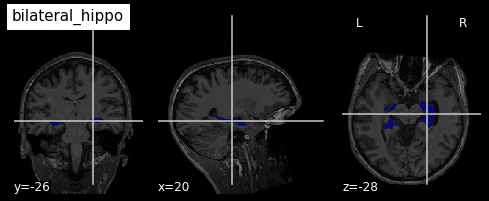

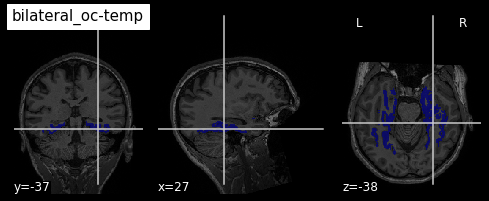

In [24]:
# load voxel x TR data for each ROI
mask_list = ROIs
masked_data = []
masked_data_all = [0] * len(mask_list)

for mask_counter in range(len(mask_list)):
    # load the mask for the corresponding ROI
    this_mask = mask_list[mask_counter]

    #if this_mask == 'bilateral_hippo':
    #    mask_fold=mask_fold_other
    #else:
        #mask_fold=mask_fold_hipp

    mask = load_adderzip_mask(mask_list[mask_counter], sub)

    # plot mask overlayed on subject's T1
    plot_roi(mask, bg_img=t1_img, title=this_mask)

    # Load in data from matlab
    in_file = (adderzip_bids_dir + 'derivatives/firstlevel/%s/masked_epi_data_v1/threshold-75/%s_task-%s_run-0%i_space-T1w_trim%dandEndTRs_mask-%s.mat' % (sub, sub, task, run, n_trunc_beginning, this_mask))
    masked_data = scipy.io.loadmat(in_file);
    masked_data = np.array(masked_data['data']);
    masked_data_all[mask_counter] = masked_data

voxel by TR matrix - shape:  bilateral_hippo (1950, 144)
voxel by TR matrix - shape:  bilateral_oc-temp (6428, 144)


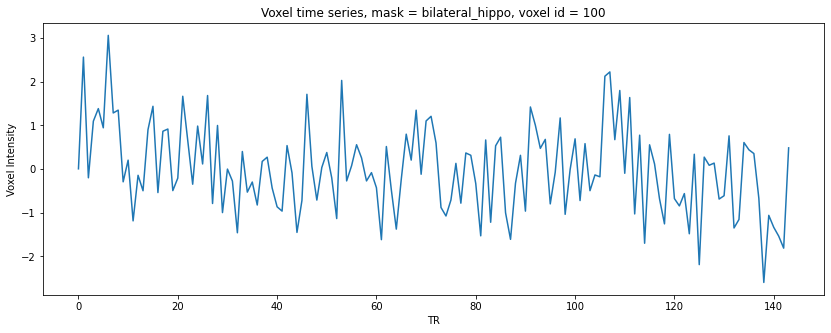

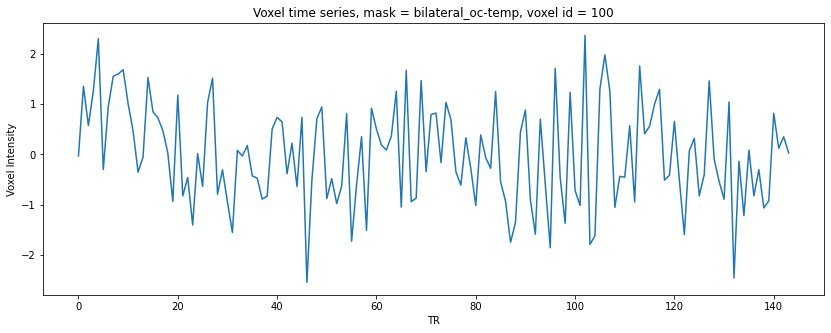

In [25]:
# check dimensionality of the data and plot value of voxel_id across timeseries; make sure data are z-scored 
num_voxels = [0] * len(mask_list)

voxel_id = 100
for mask_counter in range(len(mask_list)):
    this_mask = mask_list[mask_counter]
    print('voxel by TR matrix - shape: ', this_mask, masked_data_all[mask_counter].shape)
    num_voxels[mask_counter] = masked_data_all[mask_counter].shape[0] #save number of voxels in each mask
    
    f, ax = plt.subplots(1,1, figsize=(14,5))
    ax.plot(masked_data_all[mask_counter][voxel_id,:])

    ax.set_title('Voxel time series, mask = %s, voxel id = %d' % (this_mask, voxel_id))
    ax.set_xlabel('TR')
    ax.set_ylabel('Voxel Intensity')
    

## Reshape labels and data 
Extract the time points for which we have stimulus labels. For classifier B, we remove all rest TRs. 

In [26]:
# Extract bold data for non-zero labels
print('label list - shape: ', stim_label_shifted.shape)

def reshape_data(stim_label_shifted, masked_data_roi):
    label_index = np.float64(stim_label_shifted[:,1])
    label_index = label_index.astype(int)
    #print(label_index)
    
    # Pull out the indexes
    indexed_data = np.transpose(masked_data_roi[:,label_index])
    nonzero_labels = stim_label_shifted[:,2]
    return indexed_data, nonzero_labels

# Pull out the data from this ROI for these time points

bold_data_reshaped = [0] * len(mask_list)

for mask_counter in range(len(mask_list)):
    this_mask = mask_list[mask_counter]
    print(this_mask)

    masked_data_roi = masked_data_all[mask_counter]

    bold_data, labels = reshape_data(stim_label_shifted, masked_data_roi)

    bold_data_reshaped[mask_counter] = bold_data

    # What is the dimensionality of the data? We need the first dim to be the same
    print('The %s has the dimensionality of: %d time points by %d voxels' % (this_mask, bold_data.shape[0], bold_data.shape[1]))

    print(labels)

    print('bold data for ',this_mask,'has shape',bold_data.shape)
    
    print('')
    print('bold data for ',this_mask,'looks like this')
    print(bold_data[:5,:])
    print('...')
    print(bold_data[-5:,:])

    np.savetxt(data_dir+'/bold_data_imagine/'+this_mask+'/bold_run-0'+str(run)+'_'+subNum+'.csv', bold_data, fmt='%f', delimiter=",")
    np.savetxt(data_dir+'/label_list_imagine/labels_run-0'+str(run)+'_'+subNum+'.csv', labels, fmt='%f', delimiter=",")

label list - shape:  (144, 3)
bilateral_hippo
The bilateral_hippo has the dimensionality of: 144 time points by 1950 voxels
[0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
bold data for  bilateral_hippo has shape (144, 1950)

bold data for  bilateral_hippo looks like this
[[-1.52 -2.48 -1.53 ...  1.62 -0.57  0.59]
 [-1.24  1.29 -0.   ... -1.24 -0.5  -0.22]
 [ 0.52 -1.25 -1.95 ... -0.24 -0.76 -0.34]
 [-1.5  -0.38  0.66 ...  0.5   0.86 -0.39]
 [-0.71 -0.77  0.52 ...  1.06  0.07  0.98]]
...
[[-0.09  2.18  0.27 ...  0.89  1.87 -0.78]
 [-0.05 -0.11 -0.21 ...  0.28  0.02 -0.5 ]
 [ 0.23 -0.11 -0.08 ...  0.11 

In [23]:
# How many labels corresponding to each category? 
print('Labels = %s' % (adderzip_label_dict))
find_zeros = np.where(labels[:] == 0)[0] #to double check that numbers line up
find_ones = np.where(labels[:] == 1)[0] #to double check that numbers line up
#find_twos = np.where(labels[:] == '1.0')[0] #to double check that numbers line up
#find_threes = np.where(labels[:] == '3.0')[0] #to double check that numbers line up
#print("number of rest timepoints:", find_zeros.shape[0])

print("number of face timepoints:", len(find_ones))
print("number of scene timepoints:", len(find_zeros))


Labels = {0: 'Scenes', 1: 'Faces'}
number of face timepoints: 135
number of scene timepoints: 225


## Run classifier - logistic regression
Feed train set and get probability back for test set

In [24]:
def classifier(bold_train, labels_train, bold_test, labels_test, model,linReg):
    # normalize the data 
    scaler = StandardScaler()
    bold_train = scaler.fit_transform(bold_train)
    bold_test = scaler.fit_transform(bold_test)


    # Fit the model
    model.fit(bold_train, labels_train)

    # Compute your evaluation on the test set
    score = model.score(bold_test, labels_test)
    print('Accuracy = %s' % score)
    
    if linReg == 1:
        prediction = model.predict(bold_test)
        prediction_prob = model.predict_proba(bold_test)
    else:
        prediction = 'NA'
        prediction_prob = 'NA'
    
    return score, prediction, prediction_prob

model_linearSVC = LinearSVC(C=1)
model_linReg_1 = LogisticRegression(C=1.0, random_state=34, solver='liblinear')

In [27]:
def split(bold_data,labels,trials_run_imagine):
    
    run1_bold = bold_data[0:TRs_run_imagine,:]
    run1_labels = labels[0:TRs_run_imagine]

    run2_bold = bold_data[TRs_run_extra_imagine:,:]
    run2_labels = labels[TRs_run_extra_imagine:]

    return run1_bold,run1_labels,run2_bold,run2_labels

In [30]:
for mask_counter in range(len(mask_list)):
    this_mask = mask_list[mask_counter]
    
    print(this_mask)
    
    #split data
    run1_bold,run1_labels,run2_bold,run2_labels = split(bold_data_reshaped[mask_counter],labels,trials_run_imagine)

    #try linear regression 
    score,prediction,prediction_prob = classifier(run1_bold,run1_labels,run2_bold,run2_labels,model_linReg_1,1)
    score,prediction,prediction_prob = classifier(run2_bold,run2_labels,run1_bold,run1_labels,model_linReg_1,1)



bilateral_hippo
Accuracy = 0.5416666666666666
Accuracy = 0.5486111111111112
bilateral_oc-temp
Accuracy = 0.5347222222222222
Accuracy = 0.5555555555555556


Accuracy = 0.7666666666666667
Accuracy = 0.8666666666666667
Accuracy = 0.8666666666666667


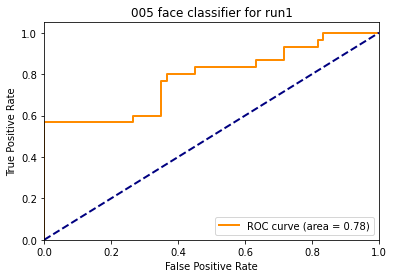

Accuracy = 0.7666666666666667
Accuracy = 0.8666666666666667
Accuracy = 0.8666666666666667


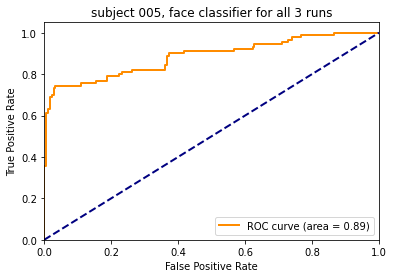

Accuracy = 0.7111111111111111
Accuracy = 0.7666666666666667
Accuracy = 0.7333333333333333


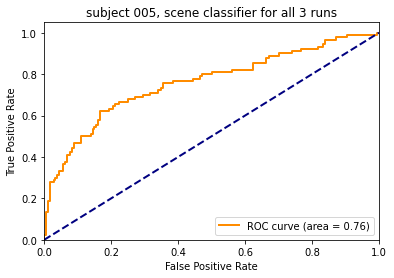

Accuracy = 0.43333333333333335
Accuracy = 0.6888888888888889
Accuracy = 0.5666666666666667


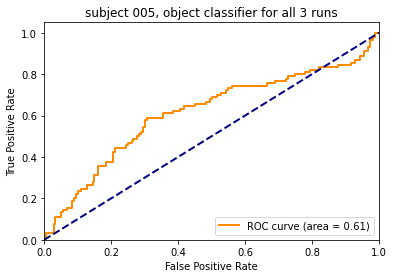

In [48]:
# binary classification of category vs. not category
n_classifierTypes = 3
totalTrials = trials_run_localizer * n_runs_localizer * n_classifierTypes
partiData = np.zeros((totalTrials,6))

#subject
partiData[:,0] = subNum

#classifier type
ones_c = np.ones(trials_run_localizer* n_runs_localizer)
twos_c = np.ones(trials_run_localizer* n_runs_localizer)*2
threes_c = np.ones(trials_run_localizer* n_runs_localizer)*3
classiCol = np.hstack((ones_c,twos_c,threes_c))
partiData[:,1] = classiCol

#run
ones = np.ones(trials_run_localizer)
twos = np.ones(trials_run_localizer)*2
threes = np.ones(trials_run_localizer)*3
runCol = np.hstack((ones,twos,threes))
runCol = np.tile(runCol, n_classifierTypes)
partiData[:, 2] = runCol

#TR
TRs_oneRun = np.arange(1,(trials_run_localizer+1))
TRsCol = np.tile(TRs_oneRun,n_runs_localizer)
TRsCol = np.tile(TRsCol,n_classifierTypes)
partiData[:,3] = TRsCol

# print('partiData')
# print(partiData.shape)
# print(partiData)

#face vs. non-face
labels_face = np.copy(labels)
labels_face[find_ones] = 1
labels_face[find_twos] = 0
labels_face[find_threes] = 0

fold1_bold_train,fold2_bold_train,fold3_bold_train,fold1_labels_train,fold2_labels_train,fold3_labels_train,fold1_bold_test,fold2_bold_test,fold3_bold_test,fold1_labels_test,fold2_labels_test,fold3_labels_test = split(bold_data,labels_face,trials_run_localizer)

fold1_score,fold1_prediction,fold1_prediction_prob = classifier(fold1_bold_train,fold1_labels_train,fold1_bold_test,fold1_labels_test,model_linReg_1,1)
fold2_score,fold2_prediction,fold2_prediction_prob = classifier(fold2_bold_train,fold2_labels_train,fold2_bold_test,fold2_labels_test,model_linReg_1,1)
fold3_score,fold3_prediction,fold3_prediction_prob = classifier(fold3_bold_train,fold3_labels_train,fold3_bold_test,fold3_labels_test,model_linReg_1,1)


y_true = fold1_labels_test
#y_true = partiData[start:(start + trials_run_localizer * n_runs_localizer),4]
y_true = list(y_true)
#print(y_true)
y_scores = fold1_prediction_prob[:,1]
#y_scores = partiData[start:(start + trials_run_localizer * n_runs_localizer),5]
#print(y_scores)
fpr,tpr,threshold = roc_curve(y_true,y_scores,pos_label='1')

roc_auc = auc(fpr,tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
        lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
title='%s face classifier for run1' % (subNum)
plt.title(title)
plt.legend(loc="lower right")
plt.show()
    
# partiData[0:trials_run_localizer,4] = fold1_labels_test
# partiData[trials_run_localizer:(trials_run_localizer*2),4] = fold2_labels_test
# partiData[(trials_run_localizer*2):(trials_run_localizer*3),4] = fold3_labels_test

# partiData[0:trials_run_localizer,5] = fold1_prediction_prob[:,1]
# partiData[trials_run_localizer:(trials_run_localizer*2),5] = fold2_prediction_prob[:,1]
# partiData[(trials_run_localizer*2):(trials_run_localizer*3),5] = fold3_prediction_prob[:,1]

# # print('partiData')
# # print(partiData.shape)
# # print(partiData)

# #scene vs. non-scene
# labels_scene = np.copy(labels)
# labels_scene[find_ones] = 0
# labels_scene[find_twos] = 1
# labels_scene[find_threes] = 0

# fold1_bold_train,fold2_bold_train,fold3_bold_train,fold1_labels_train,fold2_labels_train,fold3_labels_train,fold1_bold_test,fold2_bold_test,fold3_bold_test,fold1_labels_test,fold2_labels_test,fold3_labels_test = split(bold_data,labels_scene,trials_run_localizer)

# fold1_score,fold1_prediction,fold1_prediction_prob = classifier(fold1_bold_train,fold1_labels_train,fold1_bold_test,fold1_labels_test,model_linReg_1,1)
# fold2_score,fold2_prediction,fold2_prediction_prob = classifier(fold2_bold_train,fold2_labels_train,fold2_bold_test,fold2_labels_test,model_linReg_1,1)
# fold3_score,fold3_prediction,fold3_prediction_prob = classifier(fold3_bold_train,fold3_labels_train,fold3_bold_test,fold3_labels_test,model_linReg_1,1)

# partiData[270:(270+trials_run_localizer),4] = fold1_labels_test
# partiData[(270+trials_run_localizer):(270+trials_run_localizer*2),4] = fold2_labels_test
# partiData[(270+trials_run_localizer*2):(270+trials_run_localizer*3),4] = fold3_labels_test

# partiData[270:(270+trials_run_localizer),5] = fold1_prediction_prob[:,1]
# partiData[(270+trials_run_localizer):(270+trials_run_localizer*2),5] = fold2_prediction_prob[:,1]
# partiData[(270+trials_run_localizer*2):(270+trials_run_localizer*3),5] = fold3_prediction_prob[:,1]

# #object vs. non-object
# labels_object = np.copy(labels)
# labels_object[find_ones] = 0
# labels_object[find_twos] = 0
# labels_object[find_threes] = 1

# fold1_bold_train,fold2_bold_train,fold3_bold_train,fold1_labels_train,fold2_labels_train,fold3_labels_train,fold1_bold_test,fold2_bold_test,fold3_bold_test,fold1_labels_test,fold2_labels_test,fold3_labels_test = split(bold_data,labels_object,trials_run_localizer)

# fold1_score,fold1_prediction,fold1_prediction_prob = classifier(fold1_bold_train,fold1_labels_train,fold1_bold_test,fold1_labels_test,model_linReg_1,1)
# fold2_score,fold2_prediction,fold2_prediction_prob = classifier(fold2_bold_train,fold2_labels_train,fold2_bold_test,fold2_labels_test,model_linReg_1,1)
# fold3_score,fold3_prediction,fold3_prediction_prob = classifier(fold3_bold_train,fold3_labels_train,fold3_bold_test,fold3_labels_test,model_linReg_1,1)

# partiData[540:(540+trials_run_localizer),4] = fold1_labels_test
# partiData[(540+trials_run_localizer):(540+trials_run_localizer*2),4] = fold2_labels_test
# partiData[(540+trials_run_localizer*2):(540+trials_run_localizer*3),4] = fold3_labels_test

# partiData[540:(540+trials_run_localizer),5] = fold1_prediction_prob[:,1]
# partiData[(540+trials_run_localizer):(540+trials_run_localizer*2),5] = fold2_prediction_prob[:,1]
# partiData[(540+trials_run_localizer*2):(540+trials_run_localizer*3),5] = fold3_prediction_prob[:,1]

#print('partiData')
#print(partiData.shape)
#print(partiData)


#print(fold1_labels_test.shape)
#print(fold1_prediction)
#print(fold1_prediction_prob[:,1].shape)

for eachClassi in range(n_classifierTypes):
    
    if eachClassi == 0:
        labels = labels_face
        classiType = 'face'
    elif eachClassi == 1:
        labels = labels_scene
        classiType = 'scene'
    elif eachClassi == 2:
        labels = labels_object
        classiType = 'object'
    
    fold1_bold_train,fold2_bold_train,fold3_bold_train,fold1_labels_train,fold2_labels_train,fold3_labels_train,fold1_bold_test,fold2_bold_test,fold3_bold_test,fold1_labels_test,fold2_labels_test,fold3_labels_test = split(bold_data,labels,trials_run_localizer)

    fold1_score,fold1_prediction,fold1_prediction_prob = classifier(fold1_bold_train,fold1_labels_train,fold1_bold_test,fold1_labels_test,model_linReg_1,1)
    fold2_score,fold2_prediction,fold2_prediction_prob = classifier(fold2_bold_train,fold2_labels_train,fold2_bold_test,fold2_labels_test,model_linReg_1,1)
    fold3_score,fold3_prediction,fold3_prediction_prob = classifier(fold3_bold_train,fold3_labels_train,fold3_bold_test,fold3_labels_test,model_linReg_1,1)
    
    start = eachClassi * trials_run_localizer * n_runs_localizer
    end = eachClassi * trials_run_localizer * n_runs_localizer + trials_run_localizer
    
    partiData[start:end,4] = fold1_labels_test      
    partiData[(start+trials_run_localizer):(end+trials_run_localizer),4] = fold2_labels_test
    partiData[(start+trials_run_localizer*2):(end+trials_run_localizer*2),4] = fold3_labels_test

    partiData[start:end,5] = fold1_prediction_prob[:,1]
    partiData[(start+trials_run_localizer):(end+trials_run_localizer),5] = fold2_prediction_prob[:,1]
    partiData[(start+trials_run_localizer*2):(end+trials_run_localizer*2),5] = fold3_prediction_prob[:,1]


    #y_true = fold1_labels_test
    y_true = partiData[start:(start + trials_run_localizer * n_runs_localizer),4]
    y_true = list(y_true)
    #print(y_true)
    #y_scores = fold1_prediction_prob[:,1]
    y_scores = partiData[start:(start + trials_run_localizer * n_runs_localizer),5]
    #print(y_scores)
    fpr,tpr,threshold = roc_curve(y_true,y_scores,pos_label=1)

    roc_auc = auc(fpr,tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    title='subject %s, %s classifier for all 3 runs' % (subNum,classiType)
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

np.savetxt(data_dir+'/classifier_localizer_oc-temp/classifier_results_'+subNum+'.csv', partiData, fmt='%f', delimiter=",", header = 'subject,classifier,run,TR,trial_type,prob')


ValueError: X has 1950 features, but LogisticRegression is expecting 6428 features as input.